In [6]:
import numpy as np
import scipy
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
from collections import defaultdict
import operator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


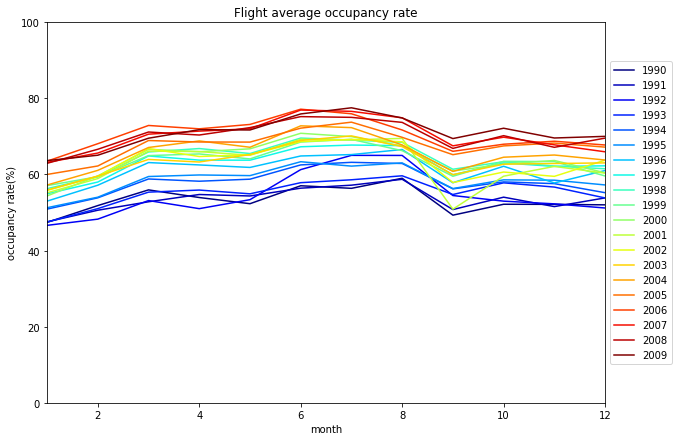

In [7]:
# Print Flight average occupancy rate for each year 

tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

position_number = defaultdict( lambda : defaultdict(list) )

for row in tsvin:
    year = int(row[8][0:4])
    month = int(row[8][4:6])
    if int(row[5])!=0:
        position_number[year][month].append(float(row[4])/float(row[5])*100)

parsedata = np.ndarray((2009-1990+1, 12))
for i in range(1990, 2010):
    if i in position_number:
        for j in range(1, 13):
            if j in position_number[i]:
                parsedata[i-1990][j-1] = sum(position_number[i][j])/float(len(position_number[i][j]))
            else:
                parsedata[i-1990][j-1] = 0
    else:
        parsedata[i-1990][:] = 0

# For plot setting
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]
x_label = range(1, 13)

plt.figure(figsize=(10,7))
plt.title("Flight average occupancy rate")
plt.xlabel("month")
plt.ylabel("occupancy rate(%)")
plt.ylim(0, 100)
plt.xlim(1, 12)
for i in range(len(parsedata)):
    plt.plot(x_label, parsedata[i], color=colors[i], label=str(i+1990))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

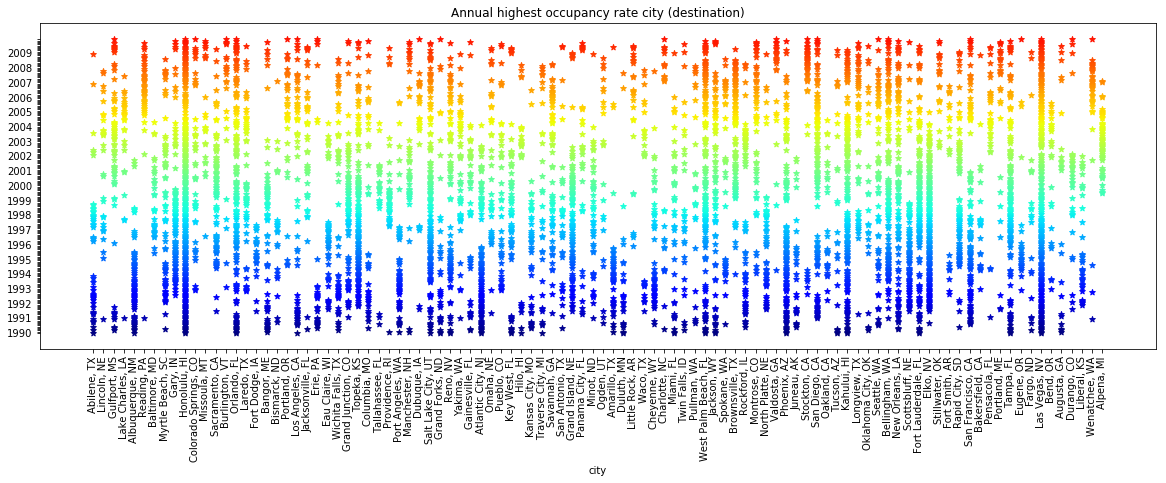

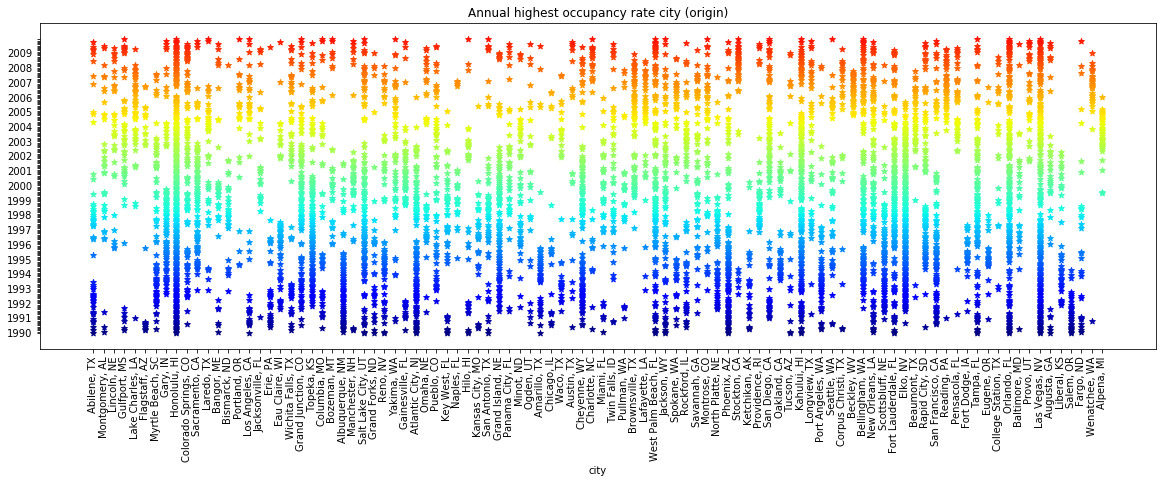

In [20]:
# Print top 20 highest occupancy rate in each month

tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

position_number = defaultdict( lambda : defaultdict(list) )
for row in tsvin:
    year = int(row[8][0:4])
    month = int(row[8][4:6])
    if int(row[5])!=0:
        position_number[year][month].append( [row[2], row[3], float(row[4])/float(row[5])*100] )

dests = []
sources = []
num_of_most = 30
for i in range(1990, 2010):
    if i in position_number:
        for j in range(1, 13):
            if j in position_number[i]:
                dest_raw = defaultdict(list)
                dest_cal = []
                source_raw = defaultdict(list)
                source_cal = []
                for item in position_number[i][j]:
                    dest_raw[item[0]].append(item[2])
                    source_raw[item[1]].append(item[2])

                for item in dest_raw:
                    average = sum(dest_raw[item])/float(len(dest_raw[item]))
                    dest_cal.append( (item, average) )

                for item in source_raw:
                    average = sum(source_raw[item])/float(len(source_raw[item]))
                    source_cal.append( (item, average) )

                dest_cal.sort(key=lambda x:x[1])
                dest_cal.reverse()
                dests.append( [dest[0] for dest in dest_cal[0:num_of_most]] )
                source_cal.sort(key=lambda x:x[1])
                source_cal.reverse()
                sources.append( [source[0] for source in source_cal[0:num_of_most]] )

dest_set = set()
dest_set_dict = defaultdict(int)
source_set_dict = defaultdict(int)
for dest_list in dests:
    for dest in dest_list:
        if dest in dest_set_dict:
            dest_set_dict[dest] += 1
        else:
            dest_set_dict[dest] = 1
for source_list in sources:
    for source in source_list:
        if source in source_set_dict:
            source_set_dict[source] += 1
        else:
            source_set_dict[source] = 1

dest_set = [dest for dest in dest_set_dict if dest_set_dict[dest]>20]
source_set = [source for source in source_set_dict if source_set_dict[source]>20]


# for plot setting
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 270)]
ylabel = []
for year in range(1990, 2010):
    ylabel.append(str(year))
    for month in range(1, 12):
        ylabel.append("")
        
plt.figure(figsize=(20, 10))
plt.xlabel('city')
plt.title("Annual highest occupancy rate city (destination)")
ax1 = plt.subplot(111)
ax1.set_xticks(range(len(dest_set)))
ax1.set_xticklabels(dest_set, rotation=90)
plt.yticks(range(len(ylabel)), ylabel)
for time in range(len(dests)):
    x = [dest_set.index(dest) for dest in dests[time] if dest in dest_set]
    y = [time]*len(x)
    plt.scatter(x, y, c=colors[time], marker='*')
box = ax1.get_position()
ax1.set_position([box.x0, box.y0+box.height*0.4, box.width, box.height*0.6])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.clf()
plt.figure(figsize=(20, 10))
plt.title("Annual highest occupancy rate city (origin)")
plt.xlabel('city')
ax2 = plt.subplot(111)
ax2.set_xticks(range(len(source_set)))
ax2.set_xticklabels(source_set, rotation=90)
plt.yticks(range(len(ylabel)), ylabel)
for time in range(len(sources)):
    x = [source_set.index(source) for source in sources[time] if source in source_set]
    y = [time]*len(x)
    plt.scatter(x, y, c=colors[time], marker='*')
box = ax2.get_position()
ax2.set_position([box.x0, box.y0+box.height*0.4, box.width, box.height*0.6])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

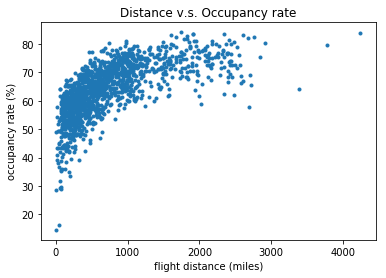

In [21]:
# Print distance vs occupancy rate

tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

filter_flight_1 = defaultdict(list)
for row in tsvin:
    if int(row[5])!=0:
        ori = row[2]
        des = row[3]
        distance = float(row[7])
        occy_rate = float(row[4])/float(row[5])*100.
        if occy_rate<=100:
            if (ori, des) in filter_flight_1:
                filter_flight_1[ (ori, des) ].append([ distance, occy_rate ])
            else:
                filter_flight_1[ (des, ori) ].append([ distance, occy_rate ])


distance = []
occupancy = []
for item_list in filter_flight_1:
    if len(filter_flight_1[item_list])>500:
        dists = [ item[0] for item in filter_flight_1[item_list] ]
        rates = [ item[1] for item in filter_flight_1[item_list] ]
        distance.append( sum(dists)/float(len(dists)) )
        occupancy.append( sum(rates)/float(len(rates)) )

plt.title("Distance v.s. Occupancy rate")
plt.xlabel("flight distance (miles)")
plt.ylabel("occupancy rate (%)")
plt.scatter(distance, occupancy, marker='.')
plt.show()

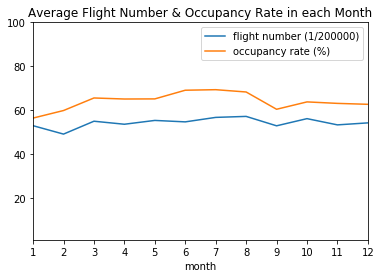

In [8]:
tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

occy_rate = defaultdict( list )
flight_num = defaultdict( list )

for row in tsvin:
    month = int(row[8][4:6])
    if int(row[5])!=0 and int(row[6])>1:
        flight_num[month].append(float(row[6]))
        occy_rate[month].append(float(row[4])/float(row[5])*100)

flight_num_avg = []
occy_rate_avg = []
for i in range(1, 13):
    flight_num_avg.append(sum(flight_num[i])/200000)
    occy_rate_avg.append(sum(occy_rate[i])/len(flight_num[i]))

plt.title("Average Flight Number & Occupancy Rate in each Month")
plt.xlabel("month")
plt.xlim(1, 12)
plt.ylim(1, 100)
plt.xticks(range(1, 13), range(1, 13))
plt.plot(range(1, 13), flight_num_avg, label="flight number (1/200000)")
plt.plot(range(1, 13), occy_rate_avg, label="occupancy rate (%)")
plt.legend()
plt.show()

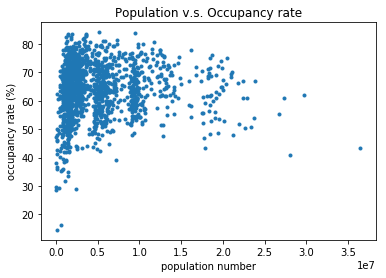

In [9]:
tsvin_f = open("flightData/flight_edges.tsv","r")
tsvin = csv.reader(tsvin_f, delimiter='\t')

filter_flight_1 = defaultdict(list)
for row in tsvin:
    if int(row[5])!=0:
        ori = row[2]
        des = row[3]
        population = float(row[10])
        occy_rate = float(row[4])/float(row[5])*100.
        if occy_rate<=100:
            if (ori, des) in filter_flight_1:
                filter_flight_1[ (ori, des) ].append([ population, occy_rate ])
            else:
                filter_flight_1[ (des, ori) ].append([ population, occy_rate ])


population = []
occupancy = []
for item_list in filter_flight_1:
    if len(filter_flight_1[item_list])>500:
        populations = [ item[0] for item in filter_flight_1[item_list] ]
        rates = [ item[1] for item in filter_flight_1[item_list] ]
        population.append( sum(populations)/float(len(populations)) )
        occupancy.append( sum(rates)/float(len(rates)) )

plt.title("Population v.s. Occupancy rate")
plt.xlabel("population number")
plt.ylabel("occupancy rate (%)")
plt.scatter(population, occupancy, marker='.')
plt.show()
